In [ ]:
#default_exp callbacks_05

In [ ]:
#export
from ModernArchitecturesFromScratch.basic_operations_01 import *
from ModernArchitecturesFromScratch.fully_connected_network_02 import *
from ModernArchitecturesFromScratch.model_training_03 import *
from ModernArchitecturesFromScratch.convolutions_pooling_04 import *
from nbdev.showdoc import *
import math
from functools import partial
import matplotlib.pyplot as plt
import time
from fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import format_time

# Callbacks
> Implementing an advanced training loop to take advantage of callbacks. Defines new wrapper classes such as databunch and learner.

# DataLoader

In [ ]:
#export
#hide
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __getitem__(self, i): return self.x[i], self.y[i]
    def __len__(self): return len(self.x)
    def __repr__(self): return f'X: {self.x.shape}, Y: {self.y.shape}'

class DataLoader():
    def __init__(self, ds, batcher, collate_fcn): self.ds, self.batcher, self.collate_fcn = ds, batcher, collate_fcn    
    def __iter__(self):
        for b in self.batcher: yield self.collate_fcn([self.ds[i] for i in b])     
    @property
    def dataset(self): return self.ds
    def __len__(self): return math.ceil(len(self.ds) / self.batcher.bs)
    def __repr__(self): return f'Data: {self.ds}, bs = {self.batcher.bs}'

In [ ]:
#export
class Databunch():
    "Wrapper to combine training and validation datasets"
    def __init__(self, train_dl, valid_dl): self.train, self.valid = train_dl, valid_dl
    
    @property
    def train_ds(self): return self.train.dataset
    
    @property
    def valid_ds(self): return self.valid.dataset
    
    def __repr__(self): return f'Databunch(\nTrain: {self.train}, \nValid{self.valid}\n)'
    
    def __len__(self): return len(self.train)

In [ ]:
#export
def get_databunch(xt, yt, xv, yv, bs=64):
    "Helper function to get a databunch of given `bs`"
    t_data, v_data = Dataset(xt, yt), Dataset(xv, yv)
    t_dl, v_dl = DataLoader(t_data, Batcher(t_data, bs, True), collate), DataLoader(t_data, Batcher(t_data, bs*2, False), collate)
    return Databunch(t_dl, v_dl)

def get_mnist_databunch():
    "Grabs MNIST databuunch usuing `get_mnist` and `get_databunch`"
    return get_databunch(*get_mnist())

In [ ]:
db = get_mnist_databunch()

In [ ]:
db

Databunch(
Train: Data: X: torch.Size([50000, 784]), Y: torch.Size([50000]), bs = 64, 
ValidData: X: torch.Size([50000, 784]), Y: torch.Size([50000]), bs = 128
)

# Learner

In [ ]:
#export
class Learner():
    def __init__(self, model, loss_func, optimizer, db, lr=0.5):
        "Wrapper for model, loss function, optimizer and databunch"
        self.model, self.loss_func, self.optimizer, self.db = model, loss_func, optimizer(model.parameters(), lr), db
    
    def __repr__(self): return f'Data: \n {self.db} \n Model: \n {self.model}'

In [ ]:
#export
def get_learner():
    "Helper function to get learner"
    m,_,lf = get_linear_model(0.1)
    db = get_mnist_databunch()
    return Learner(m,lf,Optimizer,db)

In [ ]:
learn = Learner(model, lr, Optimizer, db)
learn

Data: 
 Databunch(
Train: Data: X: torch.Size([50000, 784]), Y: torch.Size([50000]), bs = 64, 
ValidData: X: torch.Size([50000, 784]), Y: torch.Size([50000]), bs = 128
) 
 Model: 
 (Layer1): Linear(784, 50)
(Layer2): ReLU()
(Layer3): Linear(50, 10)

# Runner

In [ ]:
#export
class Runner():
    "All encompossing class to train a model with specific callbacks"
    def __init__(self, learner, cbs=None):
        cbs = [] if cbs is None else cbs
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs
        
        for cb in self.cbs:
            cb.runner = self
            
        self.learner = learner
    
    @property
    def model(self): return self.learner.model
    @property
    def optimizer(self): return self.learner.optimizer
    @property
    def loss_func(self): return self.learner.loss_func
    @property
    def databunch(self): return self.learner.db
    @property
    def dl(self): return self.learner.db.train if self.model.training else self.learner.db.valid
    
    def do_one_batch(self, xb, yb):
        "Applies forward and backward passes of model to one batch"
        self.xb, self.yb = xb, yb
        
        self.pred = self.learner.model(xb)
        self.loss = self.learner.loss_func(self.pred, yb)
        if self.check_callbacks('after_loss') or not self.learner.model.training: return
        
        self.learner.loss_func.backward()
        if self.check_callbacks('after_loss_back'): return
        
        self.learner.model.backward()
        if self.check_callbacks('after_model_back'): return
        
        self.optimizer.step()
        if self.check_callbacks('after_opt'): return
        
        self.optimizer.zero_grad()
        if self.check_callbacks('after_zero_grad'): return
    
    def do_all_batches(self, dl):
        "Runs every batch of a dataloader through `do_one_batch`"
        self.iters, self.iters_done = len(dl), 0
        for xb, yb in dl:
            if self.stop: break
            self.xb, self.yb = xb,yb
            if self.check_callbacks('before_batch'): return
            self.do_one_batch(self.xb,self.yb)
            if self.check_callbacks('after_batch'): return
        self.iters = 0
            
        self.stop = False

    def fit(self, epochs, lr=0.1):
        "Method to fit the model `epoch` times using learning rate `lr`"
        self.optimizer.lr, self.epochs = lr, epochs
        if self.check_callbacks('before_fit'): return
        
        for epoch in range(epochs):
            self.epoch = epoch
            if self.check_callbacks('before_epoch'): return
            if not self.check_callbacks('before_train'): self.do_all_batches(self.learner.db.train)
            if not self.check_callbacks('before_valid'): self.do_all_batches(self.learner.db.valid)
            if self.check_callbacks('after_epoch'): break
        
        if self.check_callbacks('after_fit'): return
    
    def check_callbacks(self, state):
        "Helper functions to run through each callback, calling it's state method if applicable"
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, state, None)
            if f and f(): return True
        return False
    
    def __repr__(self): return f'{self.learner} \n Callbacks: \n {self.cbs}'

```python
def do_one_batch(self, xb, yb):
        "Applies forward and backward passes of model to one batch"
        self.xb, self.yb = xb, yb
        
        self.pred = self.learner.model(xb)
        self.loss = self.learner.loss_func(self.pred, yb)
        if self.check_callbacks('after_loss') or not self.learner.model.training: return
        
        self.learner.loss_func.backward()
        if self.check_callbacks('after_loss_back'): return
        
        self.learner.model.backward()
        if self.check_callbacks('after_model_back'): return
        
        self.opt.step()
        if self.check_callbacks('after_opt'): return
        
        self.opt.zero_grad()
        if self.check_callbacks('after_zero_grad'): return
    
    def do_all_batches(self, dl):
        "Runs every batch of a dataloader through `do_one_batch`"
        self.iters, self.iters_done = len(dl), 0
        for xb, yb in dl:
            if self.stop: break
            if self.check_callbacks('before_batch'): return
            self.do_one_batch(xb,yb)
            if self.check_callbacks('after_batch'): return
        self.iters = 0
            
        self.stop = False

    def fit(self, epochs, lr=0.1):
        "Method to fit the model `epoch` times using learning rate `lr`"
        self.lr, self.epochs = lr, epochs
        if self.check_callbacks('before_fit'): return
        
        for epoch in range(epochs):
            self.epoch = epoch
            if self.check_callbacks('before_epoch'): return
            if not self.check_callbacks('before_train'): self.do_all_batches(self.learner.db.train)
            if not self.check_callbacks('before_valid'): self.do_all_batches(self.learner.db.valid)
            if self.check_callbacks('after_epoch'): break
        
        if self.check_callbacks('after_fit'): return
    
    def check_callbacks(self, state):
        "Helper functions to run through each callback, calling it's state method if applicable"
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, state, None)
            if f and f(): return True
        return False
    ```

In [ ]:
#export
def get_runner(callbacks=None):
    return Runner(get_learner(), list(callbacks))

In [ ]:
show_doc(Runner.__init__)

<h4 id="Runner.__init__" class="doc_header"><code>Runner.__init__</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>Runner.__init__</code>(**`learner`**, **`cbs`**=*`None`*)

Initialize self.  See help(type(self)) for accurate signature.

In [ ]:
show_doc(Runner.do_one_batch)

<h4 id="Runner.do_one_batch" class="doc_header"><code>Runner.do_one_batch</code><a href="__main__.py#L24" class="source_link" style="float:right">[source]</a></h4>

> <code>Runner.do_one_batch</code>(**`xb`**, **`yb`**)

Applies forward and backward passes of model to one batch

In [ ]:
show_doc(Runner.do_all_batches)

<h4 id="Runner.do_all_batches" class="doc_header"><code>Runner.do_all_batches</code><a href="__main__.py#L44" class="source_link" style="float:right">[source]</a></h4>

> <code>Runner.do_all_batches</code>(**`dl`**)

Runs every batch of a dataloader through `do_one_batch`

In [ ]:
show_doc(Runner.fit)

<h4 id="Runner.fit" class="doc_header"><code>Runner.fit</code><a href="__main__.py#L56" class="source_link" style="float:right">[source]</a></h4>

> <code>Runner.fit</code>(**`epochs`**, **`lr`**=*`0.1`*)

Method to fit the model `epoch` times using learning rate `lr`

In [ ]:
show_doc(Runner.check_callbacks)

<h4 id="Runner.check_callbacks" class="doc_header"><code>Runner.check_callbacks</code><a href="__main__.py#L70" class="source_link" style="float:right">[source]</a></h4>

> <code>Runner.check_callbacks</code>(**`state`**)

Helper functions to run through each callback, calling it's state method if applicable

# Callbacks

## Base Class

In [ ]:
#export
class Callback():
    "Base class for callbacks, defines order of execution and allows abstraction of self to runner class"
    _order = 0
    def __getattr__(self,k):
        #If callback doesn't have an attribute, check the runner
        return getattr(self.runner, k)

    def __repr__(self): return f'{self.__class__.__name__}'

## Built in Callback

In [ ]:
#export
class TrainEvalCallback(Callback):
    "Keeps track of training/eval mode of model and progress through training"
    _order = 10
    
    def before_fit(self):
        #self.runner.opt = self.learner.optimizer(self.learner.model.parameters(), self.lr)
        self.runner.epochs_done = 0.
        
    def before_batch(self):
        self.runner.iters_done += 1
        self.runner.epochs_done += 1/self.iters
        
    def before_valid(self):
        self.model.training = False
    
    def before_train(self):
        self.model.training = True
    
    def after_epoch(self):
        self.runner.iters_done = 0

## Metric Tracking

In [ ]:
#export
class Stat():
    "Defines a metric to keep track of through training, metric calculated using `calc`"
    def __init__(self, calc): self.calc, self.value, self.count = calc, 0., 0
    
    def __call__(self, bs, *args):
        self.value += self.calc(*args) * bs
        self.count += bs
    
    def reset(self): self.value, self.count = 0., 0
        
    def __repr__(self): return f'{(self.calc.__name__).capitalize()}: {self.value / self.count}' if self.count > 0 else f'{(self.calc.__name__).capitalize()}'
    
class StatTracker():
    "Class to implement thet `Stats` callback using metrics of class `Stat`"
    def __init__(self, metrics, in_train):
        self.in_train = in_train
        self.metrics = [Stat(m) for m in metrics]
    
    def reset(self):
        self.count, self.tot_loss = 0., 0.
        for met in self.metrics: met.reset()
    
    def __len__(self): return len(self.metrics)
    
    def accumulate(self, run):
        "Scales the metric value by the amount of data in each batch"
        bs = run.xb.shape[0]
        self.tot_loss = run.loss * bs
        self.count += bs
        for i,met in enumerate(self.metrics):
            met(bs, run.pred, run.yb)
    
    def __repr__(self):
        if self.count < 1: return ""
        else:
            printed_stats = f'Loss: {self.tot_loss / self.count}'
            for met in self.metrics:
                printed_stats += f', {met}'
            return f'{"Train" if self.in_train else "Valid"}: {printed_stats}'
    
class Stats(Callback):
    "Callback to keep track of stats passed"
    def __init__(self, metrics):
        self.train, self.valid = StatTracker(metrics, True), StatTracker(metrics, False)
    
    def before_epoch(self):
        self.train.reset()
        self.valid.reset()
    
    def after_loss(self):
        stats = self.train if self.model.training else self.valid
        stats.accumulate(self.runner)
        
    def after_epoch(self):
        print(f'Epoch: {self.epoch+1}')
        print(self.train)
        print(self.valid)

Testing the `Stats` callback:

In [ ]:
run = Runner(learn, [Stats([accuracy])])

In [ ]:
run.fit(5, 0.1)

Epoch: 1
Train: Loss: 2.3827933546272106e-06, Accuracy: 0.9668400287628174
Valid: Loss: 0.00014949109754525125, Accuracy: 0.9701799750328064
Epoch: 2
Train: Loss: 2.326479034309159e-06, Accuracy: 0.9716399908065796
Valid: Loss: 7.430403638863936e-05, Accuracy: 0.9783200025558472
Epoch: 3
Train: Loss: 4.621696461981628e-06, Accuracy: 0.9759799838066101
Valid: Loss: 0.00013563691754825413, Accuracy: 0.9827600121498108
Epoch: 4
Train: Loss: 2.2784424800192937e-06, Accuracy: 0.9796000123023987
Valid: Loss: 8.738860196899623e-05, Accuracy: 0.985040009021759
Epoch: 5
Train: Loss: 7.541702507296577e-05, Accuracy: 0.9826599955558777
Valid: Loss: 0.0008652143878862262, Accuracy: 0.94514000415802


## Parameter Scheduling

In [ ]:
#export
#hide
class Optimizer():
    def __init__(self, params, **defaults):
        #Make params a list of lists
        self.params = list(params)
        if not isinstance(self.params[0],list): self.params = list(self.params)
        self.hypes = [{**defaults} for p in self.params]
        
    def step(self): 
        for p in self.params: p.step(self.lr)
    
    def zero_grad(self): 
        for p in self.params: p.zero_grad()

In [ ]:
#export
class Scheduler(Callback):
    "Class to schedule the hyperparameters of the model"
    _order=1
    def __init__(self, param, scheduler): 
        self.param, self.sched = param, scheduler
    
    def before_batch(self):
        if self.model.training:
            for pg in self.optimizer.hypes:
                pg[self.param] = self.sched(self.epochs_done % 1)

In [ ]:
#export
def annealer(f):
    "Allows easy implementation of different scheduling functions through inner functions"
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def linear_scheduler(start, end, pos): 
    "Schedule linearly from start to end"
    return pos*(end-start) + start

@annealer
def cos_scheduler(start, end, pos): 
    "Schedule using a cosine function"
    return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2

In [ ]:
#export
def combine_scheds(pcts, scheds):
    "Combine multiple different schedules in each epoch"
    assert(sum(pcts) == 1.)
    pcts = tensor([0] + pcts)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = min((pos >= pcts).nonzero().max(), len(pcts)-2)
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [ ]:
#export
class HyperRecorder(Callback):
    "Callback to keep track of and visualize hyperparameter values and losses in the network"
    def __init__(self, params): 
        if not isinstance(params, list): params = [params]
        self.params, self.losses = {p: [] for p in params}, []
    
    def after_batch(self):
        if self.model.training:
            self.losses.append(self.loss)
            for p in self.params:
                for pg in self.optimizer.hypes:
                    self.params[p].append(pg[p])
    
    def plot_param(self,param):
        param_list = self.params[param]
        plt.plot(param_list)
    
    def plot_loss(self):
        plt.plot(self.losses)

In [ ]:
#export
#hide
class Learner():
    def __init__(self, model, loss_func, optimizer, db, lr=0.5):
        "Wrapper for model, loss function, optimizer and databunch"
        self.model, self.loss_func, self.optimizer, self.db = model, loss_func, optimizer(model.parameters(), lr=lr), db
    
    def __repr__(self): return f'Data: \n {self.db} \n Model: \n {self.model}'

Testing `HyperRecorder` and `Scheduler`

In [ ]:
start_lr = 0.01
model, _, loss_func= get_linear_model(start_lr)
db = get_mnist_databunch()
learn = Learner(model, loss_func, Optimizer, db, start_lr)

In [ ]:
schedule = combine_scheds([0.4, 0.6], [cos_scheduler(0.01,0.1), cos_scheduler(0.1,0.01)])

In [ ]:
run = Runner(learn, [Scheduler('lr', schedule), HyperRecorder(['lr'])])

In [ ]:
run.fit(2)

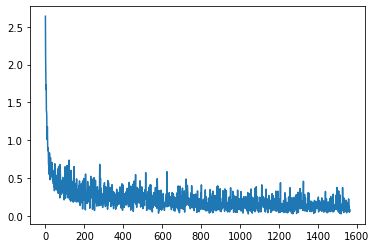

In [ ]:
run.cbs[2].plot_loss()

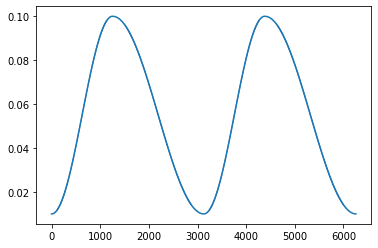

In [ ]:
run.cbs[2].plot_param('lr')

# Progress Bar

## Reformated Stats

In [ ]:
#export
#hide
def accuracy(preds, targ, *args):
    "Compute accuracy of `preds` with respect to `targ`"
    return (torch.argmax(preds, dim=1)==targ).float().mean()

In [ ]:
#export
def loss(preds, targ, loss, **kwargs):
    "Stat for loss"
    return loss

In [ ]:
#export
#hide
class Stat():
    "Defines a metric to keep track of through training, metric calculated using `calc`"
    def __init__(self, calc): self.calc, self.value, self.count = calc, 0., 0
    
    def __call__(self, bs, *args):
        self.value += self.calc(*args) * bs
        self.count += bs
    
    def reset(self): self.value, self.count = 0., 0
    
    @property
    def avg(self): return (self.value / self.count).item()
        
    def __repr__(self): return f'{(self.calc.__name__).capitalize()}: {self.value / self.count}' if self.count > 0 else f'{(self.calc.__name__).capitalize()}'
    
class StatTracker():
    "Class to implement thet `Stats` callback using metrics of class `Stat`"
    def __init__(self, metrics, in_train):
        self.in_train = in_train
        self.metrics = [Stat(loss)] + [Stat(m) for m in metrics]
    
    def reset(self):
        self.count, self.tot_loss = 0., 0.
        for met in self.metrics: met.reset()
    
    def __len__(self): return len(self.metrics)
    
    def accumulate(self, run):
        "Scales the metric value by the amount of data in each batch"
        bs = run.xb.shape[0]
        self.tot_loss = run.loss * bs
        self.count += bs
        for i,met in enumerate(self.metrics):
            met(bs, run.pred, run.yb, run.loss)
    
    def __repr__(self):
        if self.count < 1: return ""
        else:
            printed_stats = f'Loss: {self.tot_loss / self.count}'
            for met in self.metrics:
                printed_stats += f', {met}'
            return f'{"Train" if self.in_train else "Valid"}: {printed_stats}'
    
class Stats(Callback):
    "Callback to keep track of `metrics`"
    def __init__(self, metrics):
        self.train, self.valid = StatTracker(metrics, True), StatTracker(metrics, False)
        
    def before_fit(self):
        met_names = [m.calc.__name__ for m in self.train.metrics]
        names = ['epoch'] + [f'train_{n}' for n in met_names] + [
            f'valid_{n}' for n in met_names] + ['time']
        self.logger(names)
    
    def before_epoch(self):
        self.train.reset()
        self.valid.reset()
        self.start_time = time.time()
    
    def after_loss(self):
        stats = self.train if self.model.training else self.valid
        stats.accumulate(self.runner)
        
    def after_epoch(self):
        stats = [str(self.epoch)] 
        for o in [self.train, self.valid]:
            stats += [f'{v.avg:.6f}' for v in o.metrics] 
        stats += [format_time(time.time() - self.start_time)]
        self.logger(stats)

In [ ]:
# export 
class ProgressCallback(Callback):
    "Callback to make a nice progress bar with metrics for training. Slightly modified version of: https://github.com/fastai/course-v3/blob/master/nbs/dl2/09c_add_progress_bar.ipynb"
    _order=-1
    def before_fit(self):
        self.mbar = master_bar(range(self.epochs))
        self.mbar.on_iter_begin()
        self.runner.logger = partial(self.mbar.write, table=True)
        
    def after_fit(self): self.mbar.on_iter_end()
    def after_batch(self): self.pb.update(self.iters_done)
    def before_epoch(self): self.set_pb(self.databunch.train)
    def before_valid(self): self.set_pb(self.databunch.valid)
        
    def set_pb(self, dl):
        self.pb = progress_bar(dl, parent=self.mbar, auto_update=False)
        self.mbar.update(self.epoch)

Testing out the progress bar:

In [ ]:
run = get_runner([Stats([accuracy]), ProgressCallback()])

In [ ]:
run.fit(3, 0.2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.065741,0.979400,0.072409,0.977340,00:01
1,0.056172,0.982340,0.056556,0.981700,00:01
2,0.048253,0.984220,0.083364,0.973420,00:01
